In [1]:
import seaborn as sns
import time
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from matplotlib import cm as cm
from sklearn.metrics.pairwise import pairwise_distances_argmin

In [2]:
# Constant
DATASET_PATH = "dataset.csv"
NUM_CLUSTERS = 3
MAX_ITERATIONS = 10
INITIALIZE_CLUSTERS = ['k-means++', 'random']
CONVERGENCE_TOLERANCE = 0.001
NUM_THREADS = 10
BATCH_SIZE = 1000
SAMPLE_SIZE = 100000
COLORS = ['red', 'blue', 'green', 'yellow', 'gray', 'pink', 'violet', 'brown',
          'cyan', 'magenta']
FEATURES = ['start_time', 'end_time', 'avg_pressure', 'avg_dwell_time', 'avg_flight_time',
            'avg_alt_right', 'avg_alt_left', 'avg_shift_right', 'avg_shift_left',
            'avg_ctrl_right', 'avg_ctrl_left', 'avg_enter', 'avg_space', 'avg_tab',
            'error_rate', 'is_android', 'is_iphone', 'is_ipad', 'is_ipod', 'is_mac',
            'is_linux', 'is_window', 'is_blackberry', 'is_playstation', 'is_arm',
            'is_masking_agent', 'is_freebsd', 'is_osmeta', 'is_anomaly_user_agent',
            'is_empty_platform', 'user_id', 'pattern']

In [3]:
def get_dataframe_from(dataset):
    return pd.read_csv(dataset, names=FEATURES)


def normalize(data):
    return pd.DataFrame((data - data.mean()) / (data.max() - data.min())).fillna(value=-1)


def correlation_heatmap(df):
    sns.set(context="paper", font="monospace")
    corrmat = df.corr()
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 9))

    # Draw the heatmap using seaborn
    sns.heatmap(corrmat, vmax=.8, square=True)
    features = filter(lambda x: x != 'pattern' or x != 'user_id', FEATURES)
    ax.set_xticklabels(features,fontsize=6, rotation=90)
    ax.set_yticklabels(features,fontsize=6, rotation=0)
    f.tight_layout()


def print_results(k_means, time_end):
    # Obtain centroids and number Cluster of each point
    centroids = k_means.cluster_centers_
    num_cluster_points = k_means.labels_.tolist()

    print '\n\nFINAL RESULT ' + '(' + str(time_end) + '):'
    for i, c in enumerate(centroids):
        print '\tCluster %d' % (i + 1)
        print '\t\tNumber Points in Cluster %d' % num_cluster_points.count(i)
        print '\t\tCentroid: %s' % str(centroids[i])


def plot_results_kmeans(k_means, points):
    # Obtain centroids and number Cluster of each point
    centroids = k_means.cluster_centers_
    num_cluster_points = k_means.labels_.tolist()

    plt.plot()
    for nc in range(len(centroids)):
        # plot points
        points_in_cluster = [boolP == nc for boolP in num_cluster_points]
        for i, p in enumerate(points_in_cluster):
            if bool(p):
                plt.plot(points[i][0], points[i][1], linestyle='None',
                         color=COLORS[nc], marker='.')
        # plot centroids
        centroid = centroids[nc]
        plt.plot(centroid[0], centroid[1], 'o', markerfacecolor=COLORS[nc],
                 markeredgecolor='k', markersize=10)
    plt.show()


def dimension_reduction(data):
    pca = PCA(n_components=2).fit(data)
    # 2-dimensions
    return pca.transform(data)


def fit_mbk_means(data):
    #MBKMeans
    mbk_means = MiniBatchKMeans(init=INITIALIZE_CLUSTERS[0], n_clusters=NUM_CLUSTERS, batch_size=BATCH_SIZE,
                                n_init=10, max_no_improvement=10, verbose=0)
    time_start = time.time()
    mbk_means.fit(data)
    time_end = time.time() - time_start

    return mbk_means, time_end


def fit_k_means(data):
    #KMeans
    k_means = KMeans(init=INITIALIZE_CLUSTERS[0], n_clusters=NUM_CLUSTERS, n_init=10)

    time_start = time.time()
    k_means.fit(data)
    time_end = time.time() - time_start

    return k_means, time_end

def get_cluster_centers(k_means, mbk_means):
    return (np.sort(k_means.cluster_centers_, axis=0),
            np.sort(mbk_means.cluster_centers_, axis=0))


def get_labels(data, k_means_cluster_centers, mbk_means_cluster_centers):
    return (pairwise_distances_argmin(data, k_means_cluster_centers),
            pairwise_distances_argmin(data, mbk_means_cluster_centers))


def initialize_plot_params():
    fig = plt.figure(figsize=(8, 3))
    fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
    colors = ['#4EACC5', '#FF9C34', '#4E9A06']

    return fig, colors, 'train time: %.2fs\ninertia: %f'


def plot_diff_clustering(mbk_means_labels, k_means_labels, data, order, fig):
    # Initialise the different array to all False
    different = (mbk_means_labels == 4)
    ax = fig.add_subplot(1, 3, 3)

    for k in range(NUM_CLUSTERS):
        different += ((k_means_labels == k) != (mbk_means_labels == order[k]))

    identic = np.logical_not(different)
    ax.plot(data[identic, 0], data[identic, 1], 'w',
            markerfacecolor='#bbbbbb', marker='.')
    ax.plot(data[different, 0], data[different, 1], 'w',
            markerfacecolor='m', marker='.')
    ax.set_title('Difference')
    ax.set_xticks(())
    ax.set_yticks(())

def plot_clustering(labels, centers, title, order, fig, colors, axes):

    ax = fig.add_subplot(axes[0], axes[1], axes[2])
    for k, col in zip(range(NUM_CLUSTERS), colors):

        if order is None:
            my_members = labels == k
        else:
            my_members = labels == order[k]

        cluster_center = centers[k]
        ax.plot(data[my_members, 0], data[my_members, 1], 'w',
                markerfacecolor=col, marker='.')
        ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
                markeredgecolor='k', markersize=6)

    ax.set_title(title)
    ax.set_xticks(())
    ax.set_yticks(())

def clustering(data):

    #MBKMeans
    (mbk_means, time_end_mbk) = fit_mbk_means(data)

    #KMeans
    (k_means, time_end_km) = fit_k_means(data)

    # The same colors for the same cluster
    (k_means_cluster_centers, mbk_means_cluster_centers) = get_cluster_centers(k_means, mbk_means)
    (k_means_labels, mbk_means_labels) = get_labels(data, k_means_cluster_centers, mbk_means_cluster_centers)
    order = pairwise_distances_argmin(k_means_cluster_centers,
                                  mbk_means_cluster_centers)


    return k_means, mbk_means, time_end_km, time_end_mbk, k_means_labels, mbk_means_labels,\
           k_means_cluster_centers, mbk_means_cluster_centers, order



# Prepare and normalize data

In [4]:
df = get_dataframe_from(DATASET_PATH)
df.sort(['user_id'])
None

/Users/mdagostino/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [5]:
data = normalize(df.ix[:SAMPLE_SIZE, 0:30])

# Visualize correlations features

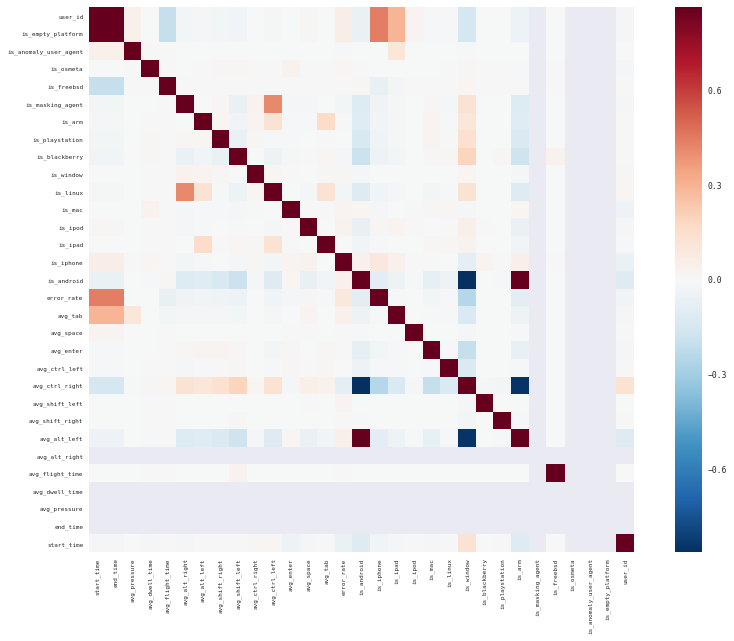

In [6]:
correlation_heatmap(df)
plt.show()

# Clustering KMeans (single)

In [ ]:
(k_means, time_end_km) = fit_k_means(data)
# Print final result
print_results(k_means, time_end_km)

In [ ]:
# Plot Final results
plot_results_kmeans(k_means, dimension_reduction(data.as_matrix()))

# Clustering KMeans Vs MiniBatchKMeans

In [7]:
(
    k_means,
    mbk_means,
    time_end_km,
    time_end_mbk,
    k_means_labels,
    mbk_means_labels,
    k_means_cluster_centers,
    mbk_means_cluster_centers,
    order
) = clustering(data)

# Dimension Reduction
data = dimension_reduction(data.as_matrix())

In [8]:
# Initialize Plot params
(figure, colors, stats) = initialize_plot_params()


# Plot KMeans

In [9]:
k_means_axes = (1, 3, 1)
plot_clustering(k_means_labels, k_means_cluster_centers, 'kmeans', None, figure, colors, k_means_axes)
plt.text(0.5, 1,  stats % (
    time_end_km, k_means.inertia_))

# Plot MBKMeans

In [10]:
mbk_means_axes = (1, 3, 2)
plot_clustering(mbk_means_labels, mbk_means_cluster_centers, 'mbk_means', order, figure, colors, mbk_means_axes)
plt.text(0.5, 1,  stats % (
    time_end_mbk, mbk_means.inertia_))

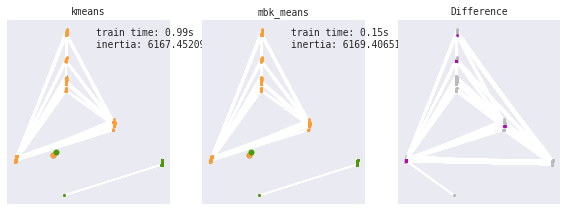

In [11]:
# Plot Differences between both algorithms
plot_diff_clustering(mbk_means_labels, k_means_labels, data, order, figure)
plt.show()